In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [22]:
df=pd.read_csv("Data/Preprocessed/Rockburst_in_Tunnel_V2.csv")

## Using SMOTE to balance the data

In [23]:

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split data
X = df.drop(columns=['Intensity_Level_encoded',"Intensity_Level"])
y = df['Intensity_Level_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE on train set only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: Intensity_Level_encoded
0    27
2    20
1    16
3     9
Name: count, dtype: int64
After SMOTE: Intensity_Level_encoded
0    27
3    27
2    27
1    27
Name: count, dtype: int64


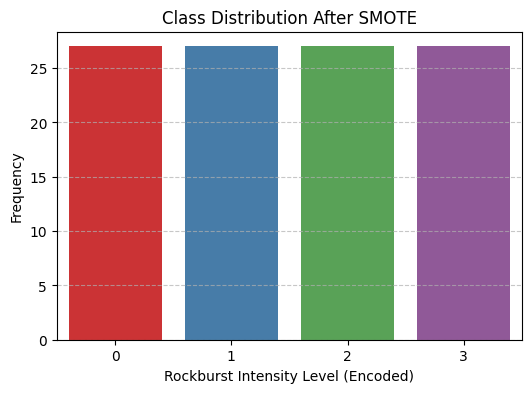

In [24]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_res, palette="Set1",hue=y_train_res,legend=False)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Rockburst Intensity Level (Encoded)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Noise Injection To increase the samples

In [25]:
# Function to add noise
def add_noise(data, noise_factor=0.01):
    noisy_data = data.copy()
    for col in noisy_data.columns:
        if np.issubdtype(noisy_data[col].dtype, np.number):
            std_dev = noisy_data[col].std()
            noise = np.random.normal(0, std_dev * noise_factor, size=noisy_data[col].shape)
            noisy_data[col] = noisy_data[col] + noise
    return noisy_data


In [26]:
target_size = 1000
augmented_X = [X_train_res]
augmented_y = [y_train_res]

while len(pd.concat(augmented_X)) < target_size:
    X_noisy = add_noise(X_train_res, noise_factor=0.01)
    augmented_X.append(X_noisy)
    augmented_y.append(y_train_res)  # Labels same rahenge

# --- Step 4: Final Dataset ---
final_X_train = pd.concat(augmented_X).reset_index(drop=True)
final_y_train = pd.concat(augmented_y).reset_index(drop=True)

# Agar size exact 1000 chahiye
final_X_train = final_X_train.iloc[:target_size]
final_y_train = final_y_train.iloc[:target_size]

print("Final Train Size:", len(final_X_train))
print(final_y_train.value_counts())

Final Train Size: 1000
Intensity_Level_encoded
0    254
1    250
3    248
2    248
Name: count, dtype: int64


In [27]:
df=pd.concat([final_X_train,final_y_train],axis=1)

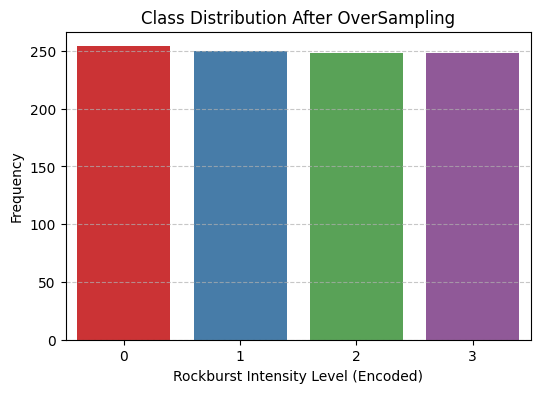

In [28]:
plt.figure(figsize=(6,4))
sns.countplot(x=final_y_train, palette="Set1",hue=final_y_train,legend=False)
plt.title("Class Distribution After OverSampling")
plt.xlabel("Rockburst Intensity Level (Encoded)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [29]:
df.head()

,Energy_Unit,Energy_density_Joule,Volume_m3,Event_freq_unit_per_day,Energy_Joule_per_day,Volume_m3_per_day,Duration_days,Energy_per_Volume,Energy_per_Duration,Volume_Change_Rate,Energy_Unit_log,Energy_density_sqr,Volume_sqr,Event_freq_unit_per_day_log,Energy_Joule_per_day_sqr,Volume_m3_per_day_sqr,Energy_per_Volume_log,Energy_per_Duration_log,Volume_Change_Rate_log,Intensity_Level_encoded
0,1.0,1.540,4.310,1.000,1.540,4.310,1.0,0.232019,1.000000,4.310000,0.693147,2.371600,18.576100,0.693147,2.371600,18.576100,0.208654,0.693147,1.669592,0
1,1.0,4.780,2.985,1.000,4.780,2.985,1.0,0.335008,1.000000,2.985000,0.693147,22.848400,8.910225,0.693147,22.848400,8.910225,0.288938,0.693147,1.382537,0
2,29.0,5.513,4.777,5.800,4.814,4.078,5.0,6.070756,5.800000,0.815600,3.401197,30.393169,22.819729,1.916923,23.174596,16.630084,1.955967,1.916923,0.596416,3
3,5.0,2.435,3.878,0.455,1.393,2.836,11.0,1.289324,0.454545,0.257818,1.791759,5.929225,15.038884,0.375006,1.940449,8.042896,0.828257,0.374693,0.229379,0
4,14.0,4.818,4.266,1.273,3.776,3.225,11.0,3.281763,1.272727,0.293182,2.708050,23.213124,18.198756,0.821101,14.258176,10.400625,1.454365,0.820981,0.257106,2


In [30]:
df.columns[:6]

Index(['Energy_Unit', 'Energy_density_Joule', 'Volume_m3',
       'Event_freq_unit_per_day', 'Energy_Joule_per_day', 'Volume_m3_per_day'],
      dtype='object')

In [31]:
train_df=df.drop(['Energy_Unit', 'Energy_density_Joule', 'Volume_m3',
       'Event_freq_unit_per_day', 'Energy_Joule_per_day', 
       'Volume_m3_per_day','Energy_per_Volume','Energy_per_Duration','Volume_Change_Rate'],axis=1)

In [32]:
train_df.head()

,Duration_days,Energy_Unit_log,Energy_density_sqr,Volume_sqr,Event_freq_unit_per_day_log,Energy_Joule_per_day_sqr,Volume_m3_per_day_sqr,Energy_per_Volume_log,Energy_per_Duration_log,Volume_Change_Rate_log,Intensity_Level_encoded
0,1.0,0.693147,2.371600,18.576100,0.693147,2.371600,18.576100,0.208654,0.693147,1.669592,0
1,1.0,0.693147,22.848400,8.910225,0.693147,22.848400,8.910225,0.288938,0.693147,1.382537,0
2,5.0,3.401197,30.393169,22.819729,1.916923,23.174596,16.630084,1.955967,1.916923,0.596416,3
3,11.0,1.791759,5.929225,15.038884,0.375006,1.940449,8.042896,0.828257,0.374693,0.229379,0
4,11.0,2.708050,23.213124,18.198756,0.821101,14.258176,10.400625,1.454365,0.820981,0.257106,2


In [33]:
train_df.describe()

,Duration_days,Energy_Unit_log,Energy_density_sqr,Volume_sqr,Event_freq_unit_per_day_log,Energy_Joule_per_day_sqr,Volume_m3_per_day_sqr,Energy_per_Volume_log,Energy_per_Duration_log,Volume_Change_Rate_log,Intensity_Level_encoded
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,8.321491,2.458569,24.726059,18.816684,0.955656,16.847946,12.081335,1.311195,0.955655,0.439057,1.490000
std,4.218003,0.912771,10.906296,4.985243,0.444784,8.196792,3.444957,0.629557,0.444880,0.270551,1.120337
min,0.914710,0.674731,0.373194,6.255175,0.100226,-0.056328,2.724534,0.201691,0.099245,0.084054,0.000000
25%,5.032642,1.797249,19.256780,15.067353,0.690507,11.938665,9.694000,0.831070,0.688187,0.286252,0.000000
50%,8.025267,2.475114,23.588248,19.123772,0.914393,16.194783,12.888243,1.290344,0.912450,0.362900,1.000000
75%,10.026226,3.135568,33.717996,22.790917,1.212516,23.492127,14.548501,1.712391,1.206679,0.497710,2.000000
max,23.045425,4.287414,50.442388,26.774776,2.081657,34.755878,18.661699,2.692011,2.082954,1.676796,3.000000


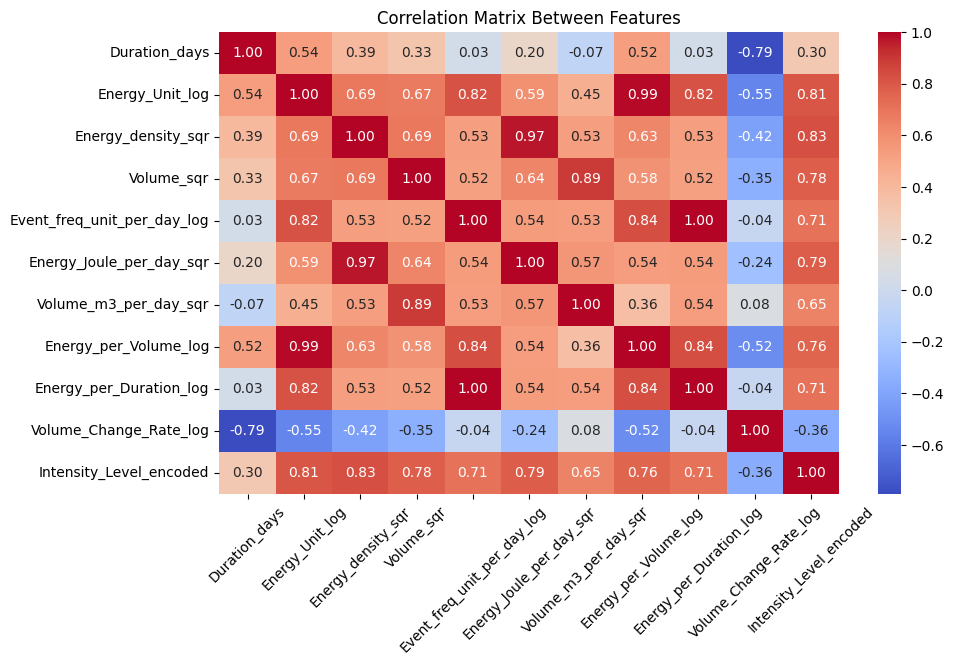

In [34]:
columns=train_df.columns
plt.figure(figsize=(10,6))
sns.heatmap(df[columns].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Between Features")
plt.xticks(rotation=45)
plt.show()


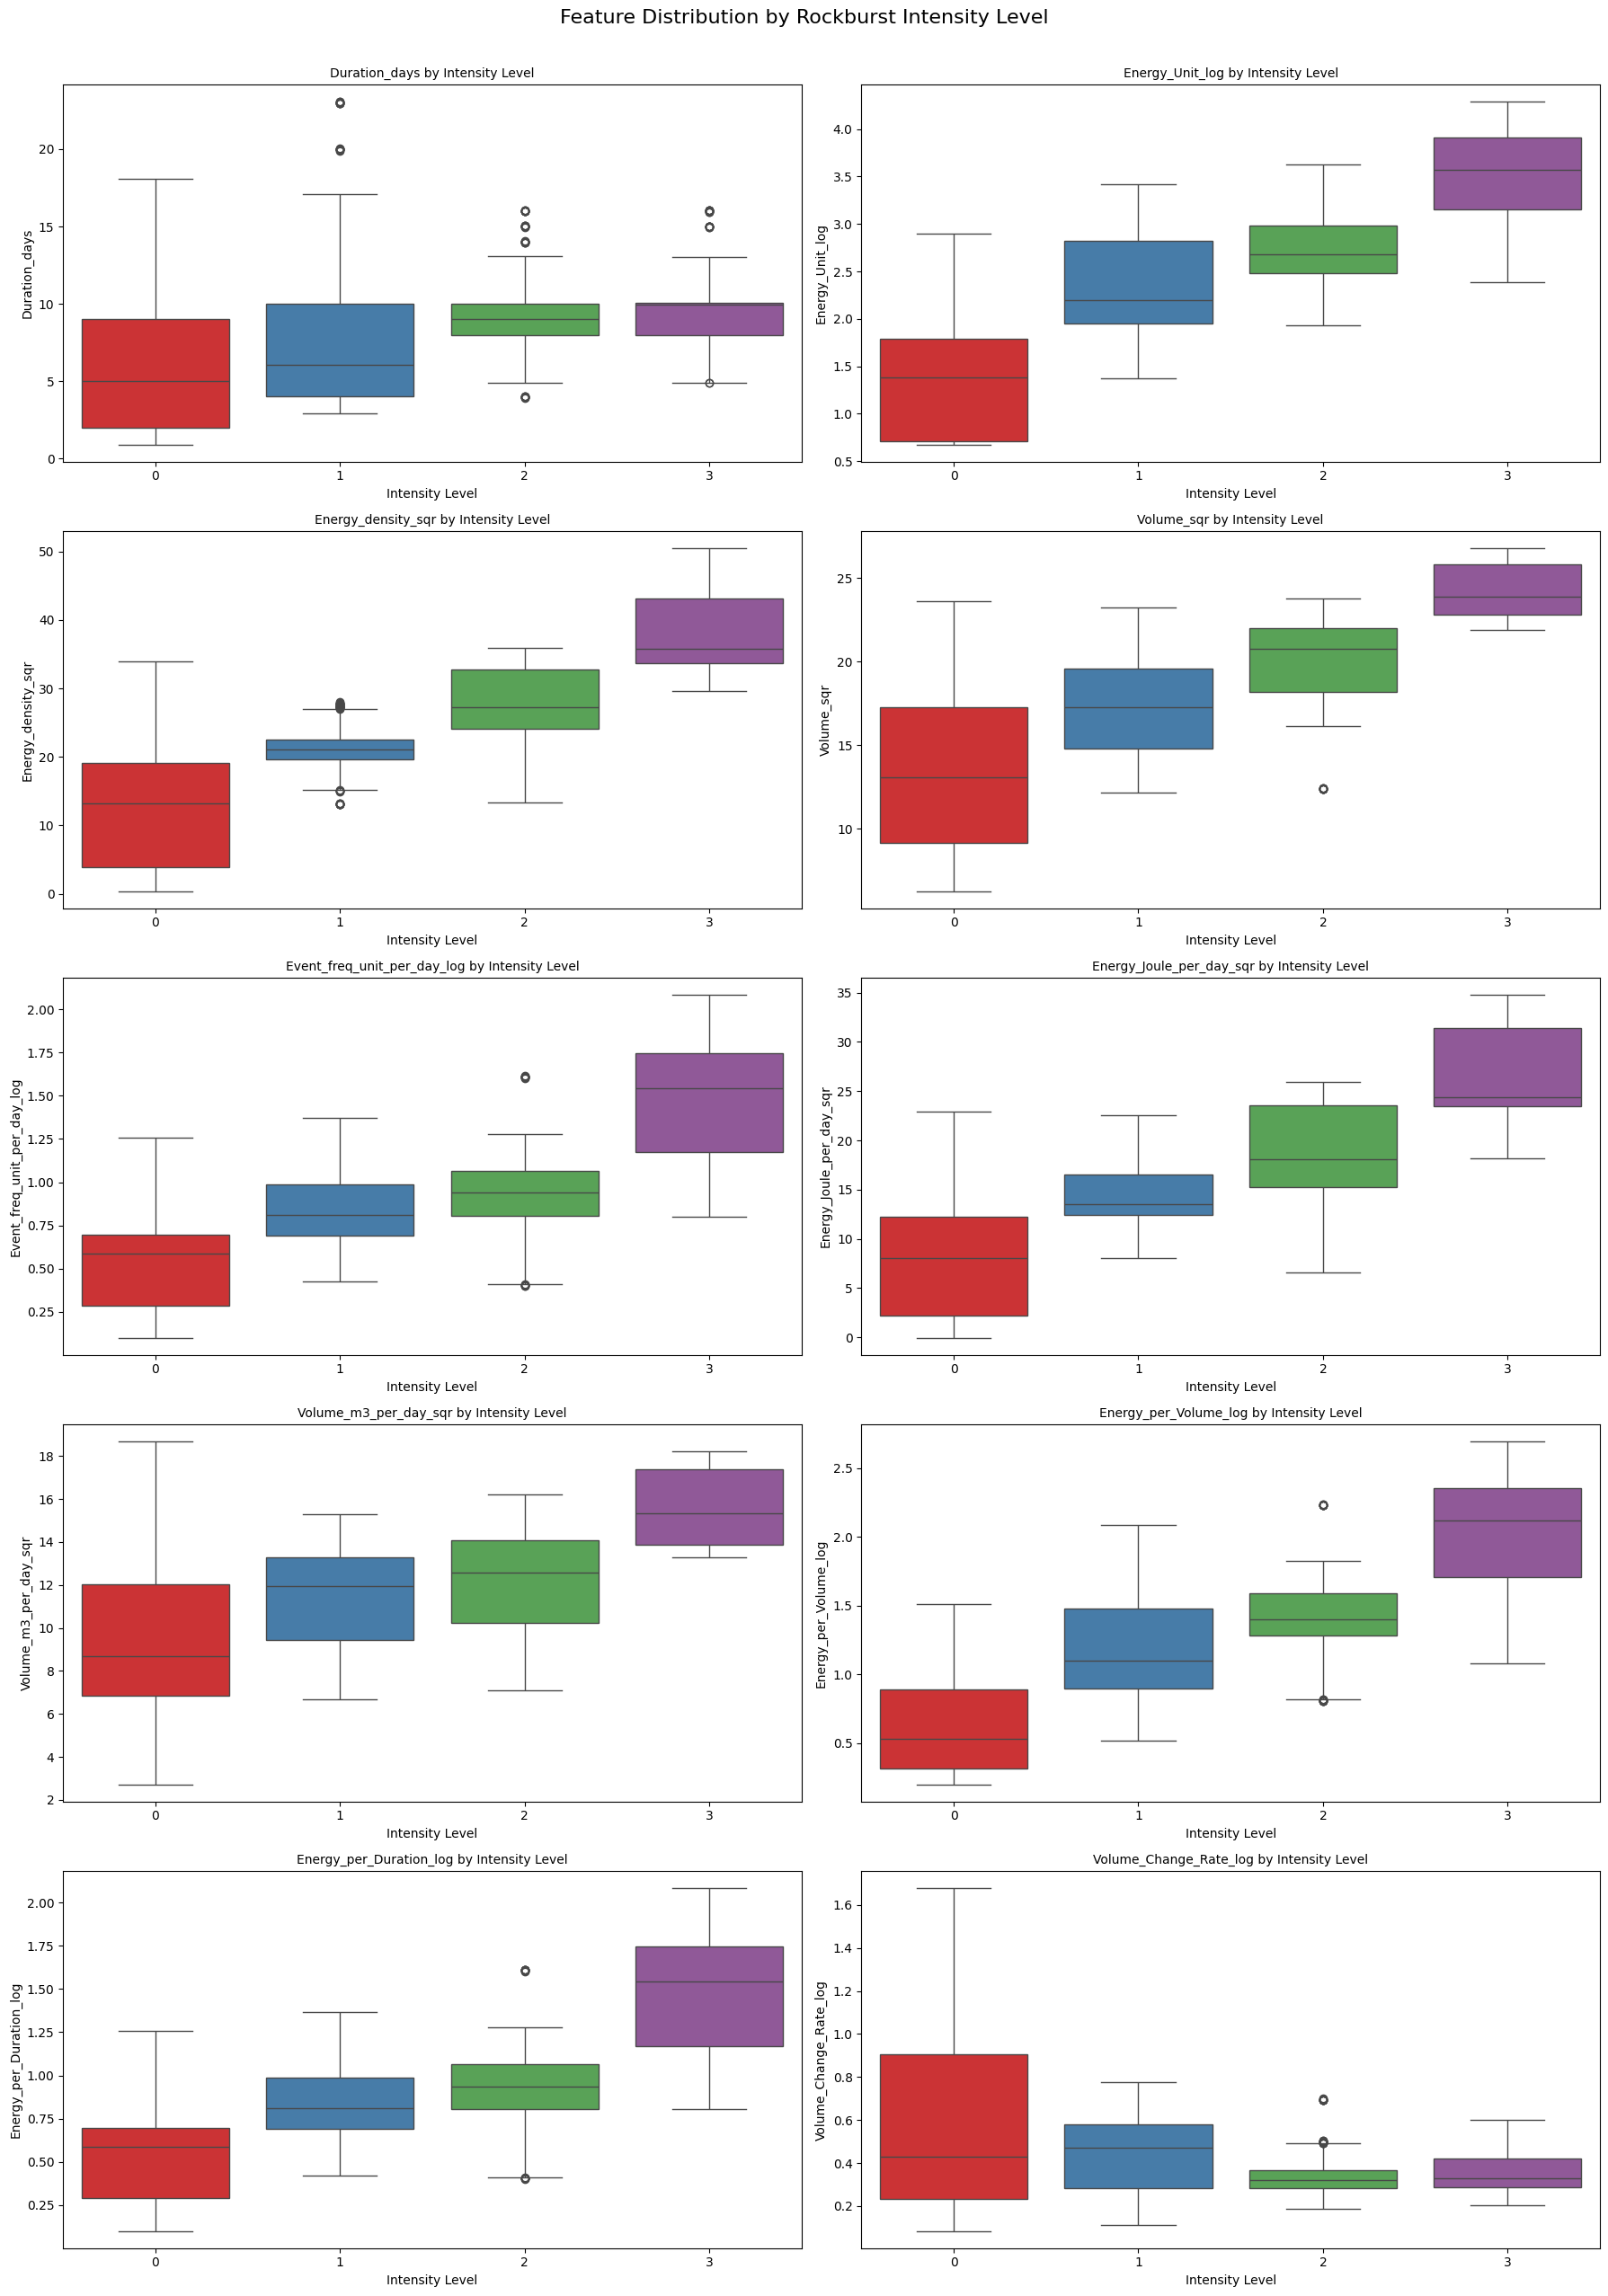

In [35]:
features = [col for col in train_df.columns if col not in ['Intensity_Level_encoded']]
n_features = len(features)

n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x='Intensity_Level_encoded', y=feature, data=train_df, palette='Set1', ax=axes[i],hue="Intensity_Level_encoded",legend=False)
    axes[i].set_title(f"{feature} by Intensity Level", fontsize=10)
    axes[i].set_xlabel("Intensity Level")
    axes[i].set_ylabel(feature)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Feature Distribution by Rockburst Intensity Level", fontsize=16, y=1.02)
plt.show()

In [36]:
train_df.to_csv("Data/Preprocessed/Rockburst_in_Tunnel_V3.csv")

In [53]:
test_df=pd.concat([X_test,y_test],axis=1)

In [55]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, 85 to 64
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Energy_Unit                  19 non-null     int64  
 1   Energy_density_Joule         19 non-null     float64
 2   Volume_m3                    19 non-null     float64
 3   Event_freq_unit_per_day      19 non-null     float64
 4   Energy_Joule_per_day         19 non-null     float64
 5   Volume_m3_per_day            19 non-null     float64
 6   Duration_days                19 non-null     int64  
 7   Energy_per_Volume            19 non-null     float64
 8   Energy_per_Duration          19 non-null     float64
 9   Volume_Change_Rate           19 non-null     float64
 10  Energy_Unit_log              19 non-null     float64
 11  Energy_density_sqr           19 non-null     float64
 12  Volume_sqr                   19 non-null     float64
 13  Event_freq_unit_per_day_lo

In [56]:
test_df.head()

,Energy_Unit,Energy_density_Joule,Volume_m3,Event_freq_unit_per_day,Energy_Joule_per_day,Volume_m3_per_day,Duration_days,Energy_per_Volume,Energy_per_Duration,Volume_Change_Rate,Energy_Unit_log,Energy_density_sqr,Volume_sqr,Event_freq_unit_per_day_log,Energy_Joule_per_day_sqr,Volume_m3_per_day_sqr,Energy_per_Volume_log,Energy_per_Duration_log,Volume_Change_Rate_log,Intensity_Level_encoded
85,11,4.110,3.624,2.200,3.411,2.925,5,3.035320,2.200000,0.585000,2.484907,16.892100,13.133376,1.163151,11.634921,8.555625,1.395086,1.163151,0.460584,3
90,6,5.300,2.735,1.500,4.698,2.133,4,2.193784,1.500000,0.533250,1.945910,28.090000,7.480225,0.916291,22.071204,4.549689,1.161207,0.916291,0.427390,0
74,8,4.132,3.504,0.615,3.018,2.390,13,2.283105,0.615385,0.183846,2.197225,17.073424,12.278016,0.479335,9.108324,5.712100,1.188790,0.479573,0.168769,1
69,3,5.060,4.438,0.429,4.215,3.593,7,0.675980,0.428571,0.513286,1.386294,25.603600,19.695844,0.356975,17.766225,12.909649,0.516398,0.356675,0.414283,2
2,17,4.754,4.397,1.889,3.800,3.443,9,3.866272,1.888889,0.382556,2.890372,22.600516,19.333609,1.060910,14.440000,11.854249,1.582328,1.060872,0.323934,2


In [ ]:
test_df.to_csv("Rockburst_")